# Analisis de incertidumbre

Notebook para analizar algoritmos cuando se tiene incertidumbre en el tiempo de partida.

En primer lugar definimos el algoritmo a estudiar (por ahora EDF o LLF)

In [1]:
Algorithm = "EDF";

In [2]:
#using Pkg;Pkg.instantiate()
#import Pkg; Pkg.add("KernelEstimator")
using EVQueues, Plots, Distributions, DataFrames, LaTeXStrings, KernelEstimator

┌ Info: Precompiling EVQueues [0ba0fc34-c32a-4e87-897a-dc4e812d5ecc]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


Your GR installation is incomplete. Rerunning build step for GR package.


ERROR: LoadError: LoadError: InitError: Evaluation into the closed module `GR` breaks incremental compilation because the side effects will not be permanent. This is likely due to some other module mutating `GR` with `eval` during precompilation - don't do this.
Stacktrace:
 [1] eval at .\boot.jl:331 [inlined]
 [2] __init__() at C:\Users\lucas\.julia\packages\GR\Hsil0\src\GR.jl:335
 [3] _include_from_serialized(::String, ::Array{Any,1}) at .\loading.jl:697
 [4] _require_from_serialized(::String) at .\loading.jl:749
 [5] _require(::Base.PkgId) at .\loading.jl:1040
 [6] require(::Base.PkgId) at .\loading.jl:928
 [7] require(::Module, ::Symbol) at .\loading.jl:923
 [8] include(::Function, ::Module, ::String) at .\Base.jl:380
 [9] include at .\Base.jl:368 [inlined]
 [10] include(::String) at C:\Users\lucas\.julia\packages\Plots\lzHOt\src\Plots.jl:1
 [11] top-level scope at C:\Users\lucas\.julia\packages\Plots\lzHOt\src\Plots.jl:218
 [12] include(::Function, ::Module, ::String) at .\Base.jl

LoadError: Failed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to C:\Users\lucas\.julia\compiled\v1.5\Plots\ld3vC_QYIS3.ji.

Se definen los parámetros para realizar las simulaciones

In [3]:
#Incertidumbre (se modela como una Uniforme)
theta=1

#Parámetros del resto de la simulación
lambda=30.0;
mu=0.5;
gamma=0.25;
C=40.0;
Tfinal=100.0;

In [4]:
function threshold(theta,lambda,mu,C)
    rho = lambda/mu
    return -1/mu*log( mu*theta*(1-C/rho)/sinh(mu*theta))
end

threshold (generic function with 1 method)

El siguiente cuadro analiza resultados de vehiculos individualmente

In [5]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edf_trace(df,C);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

if Algorithm == "EDF"
    alg_uncertain = ev_edf_trace(df2,C);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_llf_trace(df2,C);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

Simulando... 100%|██████████████████████████████████████| Time: 0:00:01


LoadError: UndefVarError: Uniform not defined

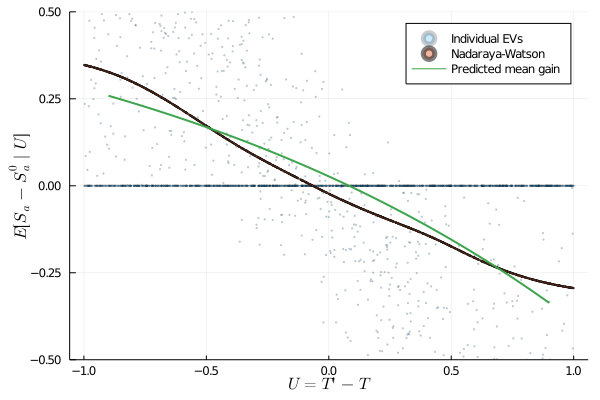

In [79]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_departure-alg_uncertain_departure;

tau = threshold(theta,lambda,mu,C)

Sa2_teo = (1.0 .-exp.(-mu*max.(-u.+tau,0)))/mu
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg-Sa_alg_uncertain);

scatter(diff_departure,Sa_alg-Sa_alg_uncertain,alpha=0.2, label="Individual EVs", ms=1, ylims=(-.5,.5))
scatter!(diff_departure,Sa_hat,alpha=0.5, label="Nadaraya-Watson", ms=1, ylims=(-.5,.5))
plot!(u,Sa2_teo.-Sa_teo,lw=2, label="Predicted mean gain", xlabel=L"U = T'-T", ylabel=L"E[S_a - S_a^0 \mid U]")
savefig(p,"MAMA1.pdf")

Analisis con curtail

In [81]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edfc_trace(df,C);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

if Algorithm == "EDF"
    alg_uncertain = ev_edfc_trace(df2,C);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_llf_trace(df2,C);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

In [48]:
function threshold2(theta,lambda,mu,C)
    rho = lambda/mu
    ktheta = (1/2 + (exp(mu*theta)-1)/(2*mu*theta))
    return -1/mu*log( (1-C/rho)/ktheta)
end

threshold2 (generic function with 1 method)

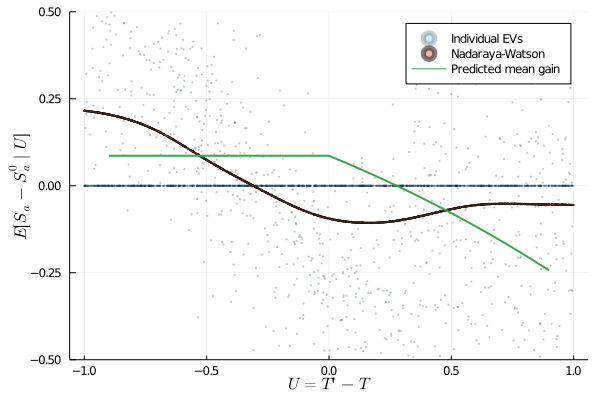

In [82]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_departure-alg_uncertain_departure;


tau2 = threshold2(theta,lambda,mu,C)
Sa3_teo = (1.0 .-exp.(-mu*max.(-u.*(u.>0).+tau2,0)))/mu
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg-Sa_alg_uncertain);

scatter(diff_departure,Sa_alg-Sa_alg_uncertain,alpha=0.2, label="Individual EVs", ms=1, ylims=(-.5,.5))
scatter!(diff_departure,Sa_hat,alpha=0.5, label="Nadaraya-Watson", ms=1, ylims=(-.5,.5))
plot!(u,Sa3_teo.-Sa_teo,lw=2, label="Predicted mean gain", xlabel=L"U = T'-T", ylabel=L"E[S_a - S_a^0 \mid U]")
savefig(p,"MAMA2.pdf")